# Preparations

In [1]:
import sys
import math
import copy
import itertools
import numpy as np
import collections

import scipy.stats
import scipy.interpolate
from scipy.optimize import curve_fit
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator

%matplotlib inline
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.mlab import griddata
from matplotlib.ticker import NullFormatter

from sklearn.preprocessing import StandardScaler

sys.path.append('..')
from higgs_inference.various.utils import interpolate, format_number, asymptotic_p_value
from higgs_inference import settings


# Settings

In [2]:
# Interpolation in final plot.
interpolation_method = 'linear' #'linear', 'gp'

# Which benchmark point to use
use_not_trained_benchmark = True

# Which algorithm to use for the PbP vs parameterized vs morphing-aware plot
use_regression_as_pbp_param_aware_example = False  # If False, use carl

# Neyman settings
neyman_plots = False
remove_duplicates_for_nc = False


In [3]:
colors     = ['black', '0.65', '#CC002E',  'c',    'mediumblue', 'darkgreen', 'orange', 'orange', '#CC002E', 'mediumblue']
linestyles = [  '-',     ':',   '--',   '-.',    ':',      '-.',          '--',        '-',         '--',  ':']
linewidths = [  1.5,     2.,    1.5,     1.5,    2.,       1.5,            1.5,         1.5,          1.5,  2]

scatter_alpha = 1.

def lighter_color(color, fraction_white=0.5):
    rgb = np.asarray(matplotlib.colors.to_rgb(color))
    white = np.asarray((1.,1.,1.))
    return fraction_white * white + (1. - fraction_white)*rgb

#for color in colors:
#    print(color, matplotlib.colors.to_rgb(color))

In [4]:
thetas = np.load('../data/thetas/thetas_parameterized.npy')

n_thetas = len(thetas)
theta1 = 708
theta_observed = 0
thetas_train = list(range(17,1017))
thetas_test = list(range(17))

if use_not_trained_benchmark:
    theta_benchmark = 9
    benchmark_name = 'nottrained'
else:
    theta_benchmark = 422
    benchmark_name = 'trained'
    
pbp_training_thetas = [0, 13, 14, 15, 16, 9, 422, 956, 666, 802, 675, 839, 699, 820, 203, 291, 634, 371, 973, 742, 901, 181, 82, 937, 510, 919, 745, 588, 804, 963, 396, 62, 401, 925, 874, 770, 108, 179, 669, 758, 113, 587, 600, 975, 496, 66, 467, 412, 701, 986, 598, 810, 97, 18, 723, 159, 320, 301, 352, 159, 89, 421, 574, 923, 849, 299, 119, 167, 939, 402, 52, 787, 978, 41, 873, 533, 827, 304, 294, 760, 890, 539, 1000, 291, 740, 276, 679, 167, 125, 429, 149, 430, 720, 123, 908, 256, 777, 809, 269, 851]
basis_thetas = [0, 101, 106, 902, 910,
                226, 373, 583, 747, 841,
                599, 709, 422, 367, 167]
thetas_highlighted = []

#print(thetas[theta1])
#print(thetas[theta_benchmark])

X_observed = np.load('../data/unweighted_events/X_test.npy')

In [5]:
margin_l_absolute = 8. * 0.1
margin_r_absolute = 8. * 0.02
margin_sep_absolute = 8. * 0.02
margin_t_absolute = 8. * 0.02
margin_b_absolute = 8. * 0.08

def calculate_height(n_panels=2, width=8.):
    
    if isinstance(n_panels, collections.Sequence):
        n_panels_h, n_panels_v = n_panels
    else:
        n_panels_h = n_panels
        n_panels_v = 1
    
    # Calculate horizontal margins. Units: relative to width.
    margin_l = margin_l_absolute / width
    margin_r = margin_r_absolute / width
    margin_l_subsequent = margin_l
    if n_panels_h > 2:
        margin_l_subsequent = margin_r
    margin_sep = margin_sep_absolute / width
    if n_panels_h > 2:
        margin_sep = 0
    margin_sep_total = margin_r + margin_sep + margin_l_subsequent
    panel_width = (1. - margin_l - margin_r - (n_panels_h - 1)*margin_sep_total) / n_panels_h
    
    # Calculate wspace argument of subplots_adjust
    wspace = margin_sep_total / panel_width
    
    # Calculate absolute height
    panel_height_absolute = panel_width * width # Square plots
    height = n_panels_v * (panel_height_absolute + margin_t_absolute + margin_b_absolute) + (n_panels_v - 1) * margin_sep_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    panel_height = panel_height_absolute / height
    margin_t = margin_t_absolute / height
    margin_b = margin_b_absolute / height
    margin_sep_total = (margin_t + margin_b + margin_sep_absolute / height)
    
    # Calculate wspace argument of subplots_adjust
    hspace = margin_sep_total / panel_height
    
    # Return height
    return height


def adjust_margins(n_panels=2, width=8.):
    
    if isinstance(n_panels, collections.Sequence):
        n_panels_h, n_panels_v = n_panels
    else:
        n_panels_h = n_panels
        n_panels_v = 1
    
    # Calculate horizontal margins. Units: relative to width.
    margin_l = margin_l_absolute / width
    margin_r = margin_r_absolute / width
    margin_l_subsequent = margin_l
    if n_panels_h > 2:
        margin_l_subsequent = margin_r
    margin_sep = margin_sep_absolute / width
    if n_panels_h > 2:
        margin_sep = 0
    margin_sep_total = margin_r + margin_sep + margin_l_subsequent
    panel_width = (1. - margin_l - margin_r - (n_panels_h - 1)*margin_sep_total) / n_panels_h
    
    # Calculate wspace argument of subplots_adjust
    wspace = margin_sep_total / panel_width
    
    # Calculate absolute height
    panel_height_absolute = panel_width * width # Square plots
    height = n_panels_v * (panel_height_absolute + margin_t_absolute + margin_b_absolute) + (n_panels_v - 1) * margin_sep_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    panel_height = panel_height_absolute / height
    margin_t = margin_t_absolute / height
    margin_b = margin_b_absolute / height
    margin_sep_total = (margin_t + margin_b + margin_sep_absolute / height)
    
    # Calculate wspace argument of subplots_adjust
    hspace = margin_sep_total / panel_height
    
    # Set margins
    plt.subplots_adjust(left = margin_l,
                        right = 1. - margin_r,
                        bottom = margin_b,
                        top = 1. - margin_t,
                        wspace = wspace)
    
#print(calculate_height(2,8.))
#print(calculate_height(3,8.))
#print(calculate_height((2,2),8.))

# Define strategies and load results

In [6]:
def _load(name, folder='parameterized'):
    return np.load('../results/' + folder + '/' + name + '.npy')

def add_strategy(label, suffix, folder,
                 suffices_ensemble=None, suffix_uncalibrated=None,
                 panel=-1, in_pbp_param_aware_plot=False, in_main_plot=True, is_truth=False,
                 zorder=None):
    
    neyman_string = 'neyman3' if remove_duplicates_for_nc else 'neyman2'
    
    try:
        _expected_llr = _load('llr_' + suffix, folder)
        _r_benchmark = _load('r_' + benchmark_name + '_' + suffix, folder)
    except IOError:
        print('Results for strategy ' + label + ' not found')
        return
    
    try:
        _mse_log_r = _load('mse_logr_' + suffix, folder)
        _trimmed_mse_log_r = _load('trimmed_mse_logr_' + suffix, folder)
        do_mse_log_r = True
    except IOError:
        _mse_log_r = None
        _trimmed_mse_log_r = None
        do_mse_log_r = False
        
    if suffix_uncalibrated is not None:
        try:
            _r_benchmark_uncalibrated = _load('r_' + benchmark_name + '_' + suffix_uncalibrated, folder)
            do_calibration = True
        except IOError:
            _r_benchmark_uncalibrated = None
            do_calibration = False
    else:
        _r_benchmark_uncalibrated = None
        do_calibration = False
        
    if suffices_ensemble is not None:
        try:
            _expected_llr_ensemble = []
            for i in range(4):
                _filename = 'llr_' + suffices_ensemble.replace(r'%i', str(i+1))
                _expected_llr_ensemble.append(_load(_filename, folder))
            do_diagnostics = True
        except IOError:
            do_diagnostics = False
            _expected_llr_ensemble = None
    else:
        do_diagnostics = False
        _expected_llr_ensemble = None
    
    try:
        _p_values = _load(neyman_string + '_pvalues_' + suffix, folder)
        _q_thresholds = _load(neyman_string + '_qcut_' + suffix, folder)
        _q_threshold_uncertainties = _load(neyman_string + '_qcut_uncertainties_' + suffix, folder)
        _q_medians = _load(neyman_string + '_qmedian_' + suffix, folder)
        do_neyman = True
        
        assert not np.all(np.isnan(_q_thresholds)), 'q thresholds contain only NaNs'
        assert not np.all(np.isnan(_q_medians)), 'q medians contain only NaNs'
        assert not np.all(np.isnan(_q_threshold_uncertainties)), 'q threshold uncertainties contain only NaNs'
    except IOError:
        _p_values = None
        _q_thresholds = None
        _q_threshold_uncertainties = None
        _q_medians = None
        do_neyman = False
    except AssertionError as err:
        _p_values = None
        _q_thresholds = None
        _q_threshold_uncertainties = None
        _q_medians = None
        do_neyman = False
        
    try:
        _recalibration_correction = -2. * settings.n_expected_events * np.log(_load('recalibration_expected_r_vs_sm_' + suffix, folder))
        do_recalibration = True
    except IOError:
        _recalibration_correction = None
        do_recalibration = False
    
    try:
        _r_roam = _load('r_roam_' + suffix, folder)
        do_roaming = True
    except IOError:
        _r_roam = None
        do_roaming = False
        
    try:
        _mle_thetas = _load('neyman_mle_' + suffix, folder)
        do_mle = True
    except IOError:
        _mle_thetas = None
        do_mle = False
        
    labels.append(label)
    suffices.append(suffix)
    
    expected_llr.append(_expected_llr)
    expected_llr_ensemble.append(_expected_llr_ensemble)
    mse_log_r.append(_mse_log_r)
    trimmed_mse_log_r.append(_trimmed_mse_log_r)
    p_values.append(_p_values)
    q_medians.append(_q_medians)
    q_threshold_uncertainties.append(_q_threshold_uncertainties)
    q_thresholds.append(_q_thresholds)
    mle_thetas.append(_mle_thetas)
    r_benchmark.append(_r_benchmark)
    r_benchmark_uncalibrated.append(_r_benchmark_uncalibrated)
    r_roam.append(_r_roam)
    recalibration_correction.append(_recalibration_correction)
    
    index = len(labels) - 1
    if is_truth:
        truth_index = index
    if panel >= 0 and panel < 3:
        panel_indices[panel].append(index)
    in_pbp_param_aware_plots.append(in_pbp_param_aware_plot)
    in_main_plots.append(in_main_plot)
    
    zorders.append(zorder)
        
    if do_neyman or do_recalibration or do_roaming or do_mle or do_diagnostics or do_calibration:
        supported = []
        if do_diagnostics:
            supported.append('ensemble')
        if do_recalibration:
            supported.append('recalibration')
        if do_neyman:
            supported.append('NC')
        if do_mle:
            supported.append('MLE')
        if do_roaming:
            supported.append('theta dependence')
        if do_calibration:
            supported.append('calibration')
        supported = ', '.join(supported)
            
        print('Loaded strategy {}: {} ({})'.format(len(labels) - 1, label, supported))
        
    else:
        print('Loaded strategy {}: {}'.format(len(labels) - 1, label))
    

In [7]:
labels = []
suffices = []
folders = []

truth_index = 0
panel_indices = ([], [])
panel_indices = ([], [], [])
in_pbp_param_aware_plots = []
in_main_plots = []

expected_llr = []
expected_llr_ensemble = []
mse_log_r = []
trimmed_mse_log_r = []
p_values = []
q_medians = []
q_thresholds = []
q_threshold_uncertainties = []
mle_thetas = []
r_benchmark = []
r_benchmark_uncalibrated = []
r_roam = []
recalibration_correction = []

zorders = []

add_strategy('Truth', 'truth', 'truth', 'truth_denom%i', 'truth_calibrated', is_truth=True)

add_strategy('Histogram', 'histo_2d_new', 'histo', 'histo_2d_denom%i', panel=0)
add_strategy('carl', 'carl_calibrated_shallow_new', 'parameterized', 'carl_calibrated_shallow_denom%i', 'carl_shallow_new', panel=0)
add_strategy('Local score regr.', 'scoreregression_score_deep_new', 'score_regression', 'scoreregression_score_deep_denom%i', panel=1)
add_strategy('Ratio regr.', 'regression_calibrated_new', 'parameterized', 'regression_calibrated_denom%i', 'regression_new', panel=1)
add_strategy('carl + score regr.', 'combined_calibrated_deep_new', 'parameterized', 'combined_calibrated_deep_denom%i', 'combined_deep_new', panel=2)
add_strategy('Ratio + score regr.', 'combinedregression_calibrated_deep_new', 'parameterized', 'combinedregression_calibrated_deep_denom%i', 'combinedregression_deep_new', panel=2)

print('')

if use_regression_as_pbp_param_aware_example:
    add_strategy('Ratio regr. point by point', 'regression_calibrated', 'point_by_point',
                 panel=-1, in_pbp_param_aware_plot=True, in_main_plot=False, zorder=2)
    add_strategy('Ratio regr. parameterized', 'regression_calibrated', 'parameterized',
                 panel=-1, in_pbp_param_aware_plot=True, in_main_plot=False, zorder=3)
    add_strategy('Ratio regr. morphing-aware', 'regression_calibrated_aware', 'parameterized',
                 panel=-1, in_pbp_param_aware_plot=True, in_main_plot=False, zorder=1)
else:
    add_strategy('carl point by point', 'carl_calibrated', 'point_by_point',
                 panel=-1, in_pbp_param_aware_plot=True, in_main_plot=False, zorder=2)
    add_strategy('carl parameterized', 'carl_calibrated_shallow', 'parameterized',
                 panel=-1, in_pbp_param_aware_plot=True, in_main_plot=False, zorder=3)
    add_strategy('carl morphing-aware', 'carl_calibrated_aware_shallow', 'parameterized',
                 panel=-1, in_pbp_param_aware_plot=True, in_main_plot=False, zorder=1)

n_strategies = len(labels)

Loaded strategy 0: Truth (ensemble, NC, MLE, theta dependence, calibration)
Loaded strategy 1: Histogram (ensemble, NC, MLE)
Loaded strategy 2: carl (ensemble, NC, MLE, theta dependence, calibration)
Loaded strategy 3: Local score regr. (ensemble, NC, MLE)
Loaded strategy 4: Ratio regr. (ensemble, NC, MLE, theta dependence, calibration)
Loaded strategy 5: carl + score regr. (ensemble, NC, MLE, theta dependence, calibration)
Loaded strategy 6: Ratio + score regr. (ensemble, recalibration, NC, MLE, theta dependence, calibration)

Loaded strategy 7: carl point by point
Loaded strategy 8: carl parameterized (theta dependence)
Loaded strategy 9: carl morphing-aware (theta dependence)


# Interpolation

In [8]:
# grid
thetas_filtered = thetas[:]
xi = np.linspace(-1.0, 1.0, 200)
yi = np.linspace(-1.0, 1.0, 200)
xx, yy = np.meshgrid(xi, yi)

# first, interpolate LLR results
interpolated_expected_llr = []
interpolated_expected_llr_mle = []
interpolated_expected_llr_median = []
interpolated_expected_llr_min = []
interpolated_expected_llr_max = []
interpolated_recalibration_correction = []

for llr, llr_ensemble, recalibration_corr in zip(expected_llr, expected_llr_ensemble, recalibration_correction):
    _llr, _mle = interpolate(thetas, llr, xx, yy, method=interpolation_method, subtract_min=False)
    _llr -= llr[settings.theta_observed]
    
    if llr_ensemble is not None:
        _llr_ensemble = [_llr]
        for i, llr_from_ensemble in enumerate(llr_ensemble):
            _llr_ens, _ = interpolate(thetas, llr_from_ensemble, xx, yy,
                                      method=interpolation_method, subtract_min=False)
            _llr_ens -= llr_ensemble[i][settings.theta_observed]
            _llr_ensemble.append(_llr_ens)
        _llr_ensemble = np.asarray(_llr_ensemble)
        
        _llr_median = np.median(_llr_ensemble, axis=0)
        _llr_min = np.min(_llr_ensemble, axis=0)
        _llr_max = np.max(_llr_ensemble, axis=0)
            
    else:
        _llr_ensemble = None
        _llr_median = _llr
        _llr_min = _llr
        _llr_max = _llr
        
    if recalibration_corr is not None:
        _rc, _ = interpolate(thetas, recalibration_corr, xx, yy, method=interpolation_method, subtract_min=False)
    else:
        _rc = None
        
    interpolated_expected_llr.append(_llr)
    interpolated_expected_llr_mle.append(_mle)
    interpolated_expected_llr_median.append(_llr_median)
    interpolated_expected_llr_min.append(_llr_min)
    interpolated_expected_llr_max.append(_llr_max)
    interpolated_recalibration_correction.append(_rc)
    
if neyman_plots:
    interpolated_q_medians = []
    interpolated_q_thresholds = []
    interpolated_cl_excluded = []

    for i, (qmed, qthresh, qthresh_err) in enumerate(zip(q_medians, q_thresholds, q_threshold_uncertainties)):
            
        print('Starting strategy {} / {}'.format(i + 1, n_strategies))

        if qmed is None or qthresh is None or qthresh_err is None:
            interpolated_q_medians.append(None)
            interpolated_q_thresholds.append(None)
            interpolated_cl_excluded.append(None)
            continue

        try:
            cut = np.all(np.isfinite(qthresh),axis=1) & (np.isfinite(qmed)) & np.all(np.isfinite(qthresh_err),axis=1)
            
            _qmed, _ = interpolate(thetas[cut], qmed[cut], xx, yy,
                                  method='gp',
                                  length_scale_default=0.1, length_scale_min=0.01, length_scale_max=1.,
                                  matern_exponent=2.5,
                                  noise_level=0.01)
            
            _qthreshs = []
            for j in range(len(settings.confidence_levels)):
                _qthresh, _ = interpolate(thetas[cut], qthresh[cut,j], xx, yy,
                                         z_uncertainties_thetas=2*qthresh_err[cut,j],
                                         method='gp',
                                         length_scale_default=1., length_scale_min=0.5, length_scale_max=2.,
                                         matern_exponent=2.5,
                                         noise_level=0.01)
                _qthreshs.append(copy.deepcopy(_qthresh))
            _qthreshs = np.asarray(_qthreshs)

            _excludeds = np.asarray([_qmed - _qthreshs[j] for j in range(_qthreshs.shape[0])])

            interpolated_q_medians.append(_qmed)
            interpolated_q_thresholds.append(_qthreshs)
            interpolated_cl_excluded.append(_excludeds)
            
            # Debug plot
            zmin, zmax = -20.,20.
            plt.figure(figsize=(10,8))

            plt.subplot(2,2,1)
            zi = np.clip(_qmed,zmin,zmax)
            cs = plt.contourf(xi, yi, zi, 100, cmap='viridis_r', vmin=zmin, vmax=zmax)
            plt.scatter(thetas[:,0], thetas[:,1], c=qmed[:],
                        s=30., lw=0.5, cmap='viridis_r', edgecolors='k', vmin=zmin, vmax=zmax)
            cbar = plt.colorbar()
            cs = plt.contour(xi, yi, zi, [settings.q_threshold],
                             linewidths=1.5, colors='w',
                             linestyles='solid')
            plt.xlim(-1.,1.)
            plt.ylim(-1.,1.)
            plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
            plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
            cbar.set_label('Median observed $q$')
            
            for j in range(len(settings.confidence_levels)):
                plt.subplot(2,2,j+2)
                zi = np.clip(_qthreshs[j], zmin, zmax)
                cs = plt.contourf(xi, yi, zi, 100, cmap='viridis_r', vmin=zmin, vmax=zmax)
                plt.scatter(thetas[:,0], thetas[:,1], c=qthresh[:,j],
                            s=30., lw=0.5, cmap='viridis_r', edgecolors='k', vmin=zmin, vmax=zmax)
                cbar = plt.colorbar()
                plt.xlim(-1.,1.)
                plt.ylim(-1.,1.)
                plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
                plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
                cbar.set_label('$q$ threshold')

            plt.tight_layout()
            plt.savefig("../figures/neyman/cl_interpolation_" + suffices[i] + ".pdf")

        except ValueError as err:
            print(err)
            interpolated_q_medians.append(None)
            interpolated_q_thresholds.append(None)
            interpolated_cl_excluded.append(None)
            
if neyman_plots:
    interpolated_cl_excluded = []
    for _qmed, _qthreshs in zip(interpolated_q_medians, interpolated_q_thresholds):
        if _qmed is None:
            interpolated_cl_excluded.append(None)
        else:
            interpolated_cl_excluded.append(np.asarray([_qmed - _qthreshs[j] for j in range(_qthreshs.shape[0])]))
            

# Calculate p values from Asimov data

In [ ]:
interpolated_p_values_asymptotics = []
interpolated_p_values_asymptotics_median = []
interpolated_p_values_asymptotics_lower_bound = []
interpolated_p_values_asymptotics_upper_bound = []

for llrs in interpolated_expected_llr:
    pvals = []
    
    for llr in llrs.flatten():
        pvals.append(asymptotic_p_value(llr, use_median_rather_than_asimov=True))
    pvals = np.asarray(pvals)
    
    pvals = pvals.reshape(llrs.shape)
    interpolated_p_values_asymptotics.append(pvals)
    
    
for medians, mins, maxs in zip(interpolated_expected_llr_median, interpolated_expected_llr_min, interpolated_expected_llr_max):
    pvals_median = []
    pvals_lower = []
    pvals_upper = []
                         
    for median, lmin, lmax in zip(medians.flatten(), mins.flatten(), maxs.flatten()):
        pvals_median.append(asymptotic_p_value(median, use_median_rather_than_asimov=True))
        pvals_lower.append(asymptotic_p_value(lmin, use_median_rather_than_asimov=True))
        pvals_upper.append(asymptotic_p_value(lmax, use_median_rather_than_asimov=True))
                         
    pvals_median = np.asarray(pvals_median)
    pvals_lower = np.asarray(pvals_lower)
    pvals_upper = np.asarray(pvals_upper)
                         
    pvals_median = pvals_median.reshape(medians.shape)
    pvals_lower = pvals_lower.reshape(medians.shape)
    pvals_upper = pvals_upper.reshape(medians.shape)
                         
    interpolated_p_values_asymptotics_median.append(pvals_median)
    interpolated_p_values_asymptotics_lower_bound.append(pvals_lower)
    interpolated_p_values_asymptotics_upper_bound.append(pvals_upper)
    

# PbP vs parameterized vs aware plot

In [ ]:
fig = plt.figure(figsize=(8., calculate_height(2,8.)))



ax = plt.subplot(1, 2, 1)

xmin, xmax = -3., 0.6
skip = 100

plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1., c='0.5')

for s in range(n_strategies):
    if in_pbp_param_aware_plots[s]:
        plt.scatter(np.log(r_benchmark[truth_index][::skip]),
                    np.log(r_benchmark[s][::skip]),
                    marker='o', alpha=1., s=10., c=colors[s], lw=0.,
                    zorder=zorders[s],
                    label=labels[s])

plt.legend(loc='lower right')

plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
plt.xlabel(r"True $\log \, r(x| \theta_0,\,\theta_1)$")
plt.ylabel(r"Learned $\log \, \hat{r}(x| \theta_0,\,\theta_1)$")


    
ax = plt.subplot(1, 2, 2)

xmin, xmax = -8., 30.
skip = 2
    
plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1., c='0.5')

for s in range(n_strategies):
    if in_pbp_param_aware_plots[s]:
        plt.scatter(expected_llr[truth_index][::skip], expected_llr[s][::skip],
                    marker='o', color=colors[s], alpha=scatter_alpha, 
                    s=8., lw=0.,
                    zorder=zorders[s],
                    label=labels[s])

plt.legend(loc='upper left')

plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
plt.xlabel(r"True $E[\log \, r(x | \theta,\,\theta_1)|\theta_{SM}]$")
plt.ylabel(r"Learned $E[\log \, \hat{r}(x | \theta,\,\theta_1)|\theta_{SM}]$")



if False:
    ax = plt.subplot(2, 2, 3)

    event = 2
    rmin, rmax = None, 1.5
    r_lines = np.array([1.,4.,9.,16.])/8.

    n_thetas_roam = 101
    xi = np.linspace(-1.0, 1.0, n_thetas_roam)
    yi = np.linspace(-1.0, 1.0, n_thetas_roam)
    xx, yy = np.meshgrid(xi, yi)

    for s, (r, l) in enumerate(zip(r_roam, labels)):
        if r is not None and (s == truth_index or in_pbp_param_aware_plots[s]):
            yi = -2. * np.log(r[event].reshape((n_thetas_roam, n_thetas_roam))[:,50])
            plt.plot(xi, yi,
                     c=colors[s], ls=linestyles[s],
                     label=l, 
                     zorder=zorders[s])

    plt.legend(loc='lower right')

    plt.xlim(-1.0, 1.0)
    plt.ylim(-0.8, 0.25)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$-2\, \log \, \hat{r}(x_e \, | \, \theta, \theta_1)$")



    ax = plt.subplot(2, 2, 4)

    thetas_filtered = thetas[:]
    xi = np.linspace(-1.0, 1.0, 200)
    yi = np.linspace(-1.0, 1.0, 200)
    xx, yy = np.meshgrid(xi, yi)
    llr_lines = [1.,4.]

    for s in range(n_strategies):
        if s == truth_index or in_pbp_param_aware_plots[s]:
            cs = plt.contour(xi, yi, interpolated_expected_llr[s], llr_lines,
                             linewidths=linewidths[s], colors=colors[s],
                             linestyles=linestyles[s])
            cs.collections[0].set_label(labels[s])

    for s in range(n_strategies):
        if s == truth_index or in_pbp_param_aware_plots[s]:
            plt.scatter([xi[interpolated_expected_llr_mle[s][1]]],
                        [yi[interpolated_expected_llr_mle[s][0]]],
                        marker='o', c=colors[s], s=50, lw=0, zorder=10)

    plt.legend(loc='upper left')

    plt.xlim(-1., 0.65)
    plt.ylim(-0.65, 1.)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")



adjust_margins(2,8.)
plt.savefig("../figures/paper/pbp_parameterized_aware.pdf")

# Calibration plots

In [ ]:
xmin, xmax = -6, 1.
skip = 100

fig = plt.figure(figsize=(9., calculate_height(3,9.)))

for panel in range(3):
    
    if panel == 0:
        ax0 = plt.subplot(1, 3, panel+1)
    else:
        ax = plt.subplot(1, 3, panel+1, sharey=ax0)

    plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1., c='0.5')
    
    order = r_benchmark_uncalibrated[truth_index].argsort()
    plt.plot(np.log(r_benchmark[truth_index][order]),
                np.log(r_benchmark_uncalibrated[truth_index][order]),
                    #marker='o', alpha=1., s=10.,
                     c=colors[truth_index], lw=1.5, ls='-',
                label=labels[truth_index])
    
    for i, s in enumerate(panel_indices[panel]):
        if r_benchmark_uncalibrated[s] is None:
            continue
        
        order = r_benchmark_uncalibrated[s].argsort()
        plt.plot(np.log(r_benchmark_uncalibrated[s][order]),
                    np.log(r_benchmark[s][order]),
                    #marker='o', alpha=1., s=10.,
                     c=colors[s], lw=1.5, ls='-',
                    label=labels[s])
        
    plt.legend(loc='lower right')
    
    plt.xlim(xmin,xmax)
    plt.ylim(xmin,xmax)
    plt.xlabel(r"Raw $\log \, \hat{r}(x| \theta_0,\,\theta_1)$")
    if panel == 0:
        plt.ylabel(r"Calibrated $\log \, \hat{r}(x| \theta_0,\,\theta_1)$")
    else:
        plt.setp(ax.get_yticklabels(), visible=False)

adjust_margins(3,9.)
plt.savefig("../figures/paper/calibration.pdf")

# Benchmark theta: approximate vs exact r(x)

In [ ]:
xmin, xmax = -3., 0.6
skip = 100

fig = plt.figure(figsize=(9., calculate_height(3,9.)))

for panel in range(3):
    
    if panel == 0:
        ax0 = plt.subplot(1, 3, panel+1)
    else:
        ax = plt.subplot(1, 3, panel+1, sharey=ax0)

    plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1., c='0.5')
    
    for i, s in enumerate(panel_indices[panel]):
        plt.scatter(np.log(r_benchmark[truth_index][::skip]),
                    np.log(r_benchmark[s][::skip]),
                    marker='o', alpha=1., s=10., c=colors[s], lw=0.,
                    label=labels[s])
        
    plt.legend(loc='lower right')
    
    plt.xlim(xmin,xmax)
    plt.ylim(xmin,xmax)
    plt.xlabel(r"True $\log \, r(x| \theta_0,\,\theta_1)$")
    if panel == 0:
        plt.ylabel(r"Learned $\log \, \hat{r}(x| \theta_0,\,\theta_1)$")
    else:
        plt.setp(ax.get_yticklabels(), visible=False)

adjust_margins(3,9.)
plt.savefig("../figures/paper/r_scatter.pdf")

# Exact vs approximate expected log likelihood ratios

In [ ]:
xmin, xmax = -8., 32.
skip = 2

fig = plt.figure(figsize=(9.,calculate_height(3,9.)))

for panel in range(3):
    
    if panel == 0:
        ax0 = plt.subplot(1, 3, panel+1)
    else:
        ax = plt.subplot(1, 3, panel+1, sharey=ax0)
    
    plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1., c='0.5')
    
    for s in panel_indices[panel]:
        plt.scatter(expected_llr[truth_index][::skip], expected_llr[s][::skip],
                    marker='o', color=colors[s], alpha=scatter_alpha, 
                    s=8., lw=0.,
                    label=labels[s])
        
    plt.legend(loc='upper left')
    
    plt.xlim(xmin, xmax)
    plt.ylim(xmin, xmax)
    plt.xlabel(r"True $E[\log \, r(x | \theta,\,\theta_1)|\theta_{SM}]$")
    if panel == 0:
        plt.ylabel(r"Learned $E[\log \, \hat{r}(x | \theta,\,\theta_1)|\theta_{SM}]$")
    else:
        plt.setp(ax.get_yticklabels(), visible=False)

adjust_margins(3,9.)
plt.savefig("../figures/paper/expected_likelihood_scatter.pdf")

# Theta dependence

In [ ]:
start_event = 25
events = list(range(start_event,start_event + 36))

rmin, rmax = None, 1.5
r_lines = np.array([1., 4., 9.])

fig = plt.figure(figsize=(8., calculate_height(2,8.)))



ax = plt.subplot(1, 2, 1)

n_thetas_roam = 101
xi = np.linspace(-1.0, 1.0, n_thetas_roam)
yi = np.linspace(-1.0, 1.0, n_thetas_roam)
xx, yy = np.meshgrid(xi, yi)

#zi_truth = -2. * np.log(r_roam[truth_index][event].reshape((n_thetas_roam, n_thetas_roam)))
#cs = plt.contourf(xi, yi, zi_truth,
#                  100, cmap="Greys", alpha=1., vmin=rmin, vmax=rmax)
#cbar = plt.colorbar()

plt.plot([0.,0.],[-1.,1.],lw=2.,ls=':',c='0.5')

for s, (r, l) in enumerate(zip(r_roam, labels)):
    if r is not None and in_main_plots[s]:
        q = -2. * np.sum(np.log(r[events]),axis=0)
        zi = q.reshape((n_thetas_roam, n_thetas_roam))
        if s == 0:
            zi_truth = zi
        plt.contour(xi, yi, zi,
                    np.min(zi_truth) + r_lines,
                    linewidths=linewidths[s], colors=colors[s],
                    linestyles=linestyles[s])

        mle = np.argmin(zi)
        plt.scatter([xx.flatten()[mle]],
                    [yy.flatten()[mle]],
                    marker='o', c=colors[s], s=50, lw=0, zorder=10)

plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
#cbar.set_label(r'$-2 \, \log \, r(x_i | \theta, \theta_1)$ (' + l + ')')
    
    
    
    
ax = plt.subplot(1, 2, 2)

i = 0
for s, (r, l) in enumerate(zip(r_roam, labels)):
    if r is not None and in_main_plots[s]:
        q = -2. * np.sum(np.log(r[events]), axis=0)
        yi = q.reshape((n_thetas_roam, n_thetas_roam))[:,50]
        plt.plot(xi, yi, c=colors[s], label=l, ls=linestyles[s])
        i += 1

plt.legend()

plt.xlim(-1.0, 1.0)
#plt.ylim(-1.0, 1.0)
plt.xlabel(r"$f_{WW} \, v^2 / \Lambda^2$")
plt.ylabel(r"$-2\, \sum_e \, \log \; \hat{r}(x_e \, | \, \theta, \theta_1)$")
    
    
adjust_margins(2,8.)
plt.savefig("../figures/paper/theta_dependence.pdf")

# CL contours from asymptotics (expected LLR contours)

In [ ]:
# Grid
thetas_filtered = thetas[:]
xi = np.linspace(-1.0, 1.0, 200)
yi = np.linspace(-1.0, 1.0, 200)
xx, yy = np.meshgrid(xi, yi)

# Error band function
def plot_errorbands(xi, yi, zi_upper, zi_lower, color):
    for threshold in np.sort(1. - settings.confidence_levels):
        band = (zi_upper > threshold) * (zi_lower < threshold) + (zi_upper < threshold) * (zi_lower > threshold)
        plt.contourf(xi, yi, band, [0.5,2.5],
                     colors=color,
                     alpha=0.2)

fig = plt.figure(figsize=(9.,calculate_height(3,9.)))

for panel in range(3):
    
    # Axis (shared y axis)
    if panel == 0:
        ax0 = plt.subplot(1, 3, panel+1)
    else:
        ax = plt.subplot(1, 3, panel+1, sharey=ax0)
        
    # Error bands (envelope)
    for s in panel_indices[panel]:
        if s < 2:
            continue
        plot_errorbands(xi, yi,
                        interpolated_p_values_asymptotics_upper_bound[s],
                        interpolated_p_values_asymptotics_lower_bound[s], 
                        colors[s])
        cs = plt.contour(xi, yi, interpolated_p_values_asymptotics_upper_bound[s], 
                         np.sort(1. - settings.confidence_levels),
                         linewidths=0.5, colors=colors[s], alpha=0.5,
                         linestyles='-')
        cs = plt.contour(xi, yi, interpolated_p_values_asymptotics_lower_bound[s], 
                         np.sort(1. - settings.confidence_levels),
                         linewidths=0.5, colors=colors[s], alpha=0.5,
                         linestyles='-')
        
    # CL contours (median)
    for s in [truth_index] + panel_indices[panel]:
        cs = plt.contour(xi, yi, interpolated_p_values_asymptotics_median[s], 
                         np.sort(1. - settings.confidence_levels),
                         linewidths=linewidths[s], colors=colors[s],
                         linestyles=linestyles[s])
        cs.collections[0].set_label(labels[s])

    # MLE
    plt.scatter([xi[interpolated_expected_llr_mle[truth_index][1]]],
                [yi[interpolated_expected_llr_mle[truth_index][0]]],
                marker='o', c=colors[truth_index], s=50, lw=0, zorder=10)
    for s in panel_indices[panel]:
        plt.scatter([xi[interpolated_expected_llr_mle[s][1]]],
                    [yi[interpolated_expected_llr_mle[s][0]]],
                    marker='o', c=colors[s], s=50, lw=0, zorder=10)

    # Legend
    plt.legend(loc='upper left')

    # Axis details
    plt.xlim(-0.95, 0.95)
    plt.ylim(-0.95, 0.95)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    if panel==0:
        plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
    else:
        plt.setp(ax.get_yticklabels(), visible=False)

adjust_margins(3,9.)
plt.savefig("../figures/paper/cl_contours_asymptotics.pdf")


In [ ]:
# Grid
thetas_filtered = thetas[:]
xi = np.linspace(-1.0, 1.0, 200)
yi = np.linspace(-1.0, 1.0, 200)
xx, yy = np.meshgrid(xi, yi)

# Error band function
def plot_errorbands(xi, yi, zi_upper, zi_lower, color):
    for threshold in np.sort(1. - settings.confidence_levels):
        band = (zi_upper > threshold) * (zi_lower < threshold) + (zi_upper < threshold) * (zi_lower > threshold)
        plt.contourf(xi, yi, band, [0.5,2.5],
                     colors=color,
                     alpha=0.2)

fig = plt.figure(figsize=(9.,calculate_height(3,9.)))

for panel in range(3):
    
    # Axis (shared y axis)
    if panel == 0:
        ax0 = plt.subplot(1, 3, panel+1)
    else:
        ax = plt.subplot(1, 3, panel+1, sharey=ax0)
        
    # Error bands (envelope)
    for s in [truth_index] + panel_indices[panel]:
        plot_errorbands(xi, yi,
                        interpolated_p_values_asymptotics[s] - interpolated_recalibration_correction[s],
                        interpolated_p_values_asymptotics[s], 
                        colors[s])
        
    # CL contours (median)
    for s in [truth_index] + panel_indices[panel]:
        cs = plt.contour(xi, yi, interpolated_p_values_asymptotics[s], 
                         np.sort(1. - settings.confidence_levels),
                         linewidths=linewidths[s], colors=colors[s],
                         linestyles=linestyles[s])
        cs.collections[0].set_label(labels[s])

    # MLE
    plt.scatter([xi[interpolated_expected_llr_mle[truth_index][1]]],
                [yi[interpolated_expected_llr_mle[truth_index][0]]],
                marker='o', c=colors[truth_index], s=50, lw=0, zorder=10)
    for s in panel_indices[panel]:
        plt.scatter([xi[interpolated_expected_llr_mle[s][1]]],
                    [yi[interpolated_expected_llr_mle[s][0]]],
                    marker='o', c=colors[s], s=50, lw=0, zorder=10)

    # Legend
    plt.legend(loc='upper left')

    # Axis details
    plt.xlim(-0.95, 0.95)
    plt.ylim(-0.95, 0.95)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    if panel==0:
        plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
    else:
        plt.setp(ax.get_yticklabels(), visible=False)

adjust_margins(3,9.)
plt.savefig("../figures/paper/cl_contours_asymptotics_expected_r_errors.pdf")



In [ ]:
# Grid
xi = np.linspace(-1.0, 1.0, 200)

# Error band function
def plot_errorbands(xi, yi_upper, yi_lower, color):
    plt.fill_between(xi, yi_upper, yi_lower,
                     color=color, alpha=0.2)

fig = plt.figure(figsize=(9.,calculate_height(3,9.)))

for panel in range(3):
    
    # Axis (shared y axis)
    if panel == 0:
        ax0 = plt.subplot(1, 3, panel+1)
    else:
        ax = plt.subplot(1, 3, panel+1, sharey=ax0)
    
    # Error bands (envelope)
    for s in panel_indices[panel]:
        if s < 2:
            continue
            
        yi_min = np.diag(interpolated_expected_llr_min[s])
        yi_max = np.diag(interpolated_expected_llr_max[s])
    
        plot_errorbands(xi, yi_min, yi_max,
                        colors[s])
        #plt.plot(xi, yi_min,
        #         lw=0.5, color=colors[s], alpha=0.5,
        #         ls='-')
        #plt.plot(xi, yi_max,
        #         lw=0.5, color=colors[s], alpha=0.5,
        #         ls='-')
        
    # CL contours (median)
    for s in [truth_index] + panel_indices[panel]:
        yi_median = np.diag(interpolated_expected_llr_median[s])
        plt.plot(xi, yi_median,
                 lw=linewidths[s], color=colors[s],
                 ls=linestyles[s], label=labels[s])

    # Legend
    plt.legend(loc='upper right')

    # Axis details
    plt.xlim(-1., 1.)
    plt.ylim(0., 28.)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2 \, = \, f_{WW} \, v^2 / \Lambda^2$")
    if panel==0:
        plt.ylabel(r"$t(\theta)$")
    else:
        plt.setp(ax.get_yticklabels(), visible=False)

adjust_margins(3,9.)
plt.savefig("../figures/paper/expected_llr_diagonal.pdf")


# CL contours from Neyman construction

In [26]:
if neyman_plots:
    fig = plt.figure(figsize=(9.,calculate_height(3,9.)))

    for panel in range(3):

        if panel == 0:
            ax0 = plt.subplot(1, 3, panel+1)
        else:
            ax = plt.subplot(1, 3, panel+1, sharey=ax0)

        for cl in range(len(interpolated_cl_excluded[truth_index])):
            cs = plt.contour(xi, yi, interpolated_cl_excluded[truth_index][cl], [0.],
                             linewidths=1.5, colors=colors[truth_index],
                             linestyles=linestyles[truth_index])
            if cl==0:
                cs.collections[0].set_label(labels[truth_index])

        for s in panel_indices[panel]:
            if interpolated_cl_excluded[s] is None:
                continue

            for cl in range(len(interpolated_cl_excluded[truth_index])):
                cs = plt.contour(xi, yi, interpolated_cl_excluded[s][cl], [0.],
                                 linewidths=linewidths[s], colors=colors[s],
                                 linestyles=linestyles[s])
                if cl==0:
                    cs.collections[0].set_label(labels[s])

        plt.legend(loc='upper left')

        plt.xlim(-0.9, 0.9)
        plt.ylim(-0.9, 0.9)
        plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
        if panel==0:
            plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
        else:
            plt.setp(ax.get_yticklabels(), visible=False)

    adjust_margins(3,9.)
    plt.savefig("../figures/paper/cl_contours_nc.pdf")

# Best fit thetas

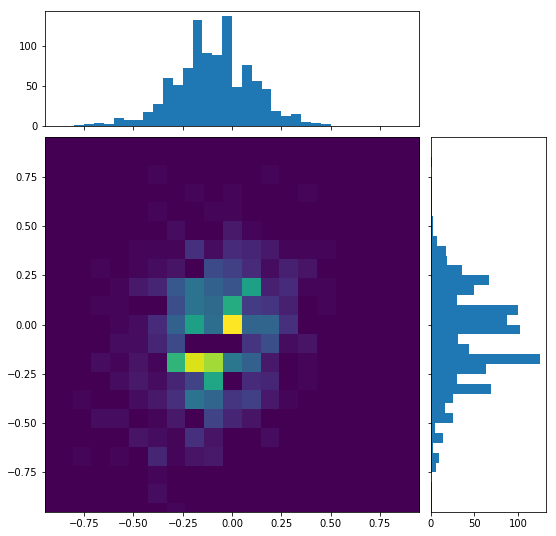

In [27]:
s = 0 # Fixed strategy for now
mle = thetas[mle_thetas[s]]

nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
axScatter.hist2d(mle[:,0], mle[:,1], range=[[-1.,1.],[-1.,1.]], bins=(21,21), normed=True, cmap='viridis')

# now determine nice limits by hand:
binwidth = 0.05
xymax = np.max([np.max(np.fabs(mle[:,0])), np.max(np.fabs(mle[:,1]))])
lim = (int(xymax/binwidth) + 1) * binwidth

axScatter.set_xlim((-lim, lim))
axScatter.set_ylim((-lim, lim))

bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(mle[:,0], bins=bins)
axHisty.hist(mle[:,1], bins=bins, orientation='horizontal')

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

plt.savefig("../figures/results/mle_scatter_truth.pdf")